# Home Work

В этой работе будем иследовать одну из популярнейших рекомендательных моделей - **Latent Factor Model** - https://arxiv.org/pdf/1912.04754.

Перед выполнением задания нужно убедиться, что прогоняется бейзлайн. Для этого:
1. Скачайте  файлы - `node2name.json` и `clickstream.parquet` с необходимыми данными.
2. Положите в репозиторий ноутбука и запустите код.

В этой работе вам нужно:
1. Перебрать параметры модели - `edim`, `batch_size`, `lr`, `epoch`, `num_negatives` - (по **1 баллу - 5 балов**)
2. Тип `OPTIMIZER_NAME` - (**4 балла за 5 оптимизаторов**)
3. На основе имеющихся данных собрать лучшую модель (по **precision@30**) и рассчитать ее метрики (**4 балла**)
4. Попробовать другие модели (например  `ALS` - https://benfred.github.io/implicit/ , `gru4rec`, `sasrec`) - за sasrec на хорошем уровне сразу **10 баллов**. За другие модели по **3 балла**
5. По окончанию работы в mlflow настроить графики для сравнения моделей. Можно проявить фантазию, но обязательно должно быть сравнение с бейзлайном (данный ноутбук) против других моделей
6. В `mlflow` залогировать последнюю версию ноутбука - необходимое условия. Либо в github, но тогда прикрепить ссылку в [mlflow](http://84.201.128.89:90/).
7. Эксперимент в формате - `homework-\<name\>`
8. Доп баллы (**20 баллов**) тому у кого будет наибольший скор на тесте. Но ваш ноутбук должен прогонятся и быть вопроизводимым.

Суммарно за работу **20 балов**.

# Installation

In [1]:
!pip freeze

absl-py==1.4.0
aiohttp==3.9.5
aiosignal==1.3.1
alabaster==0.7.16
albumentations==1.3.1
alembic==1.13.1
altair==4.2.2
aniso8601==9.0.1
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.5.1
arviz==0.15.1
astropy==5.3.4
astunparse==1.6.3
async-timeout==4.0.3
atpublic==4.1.0
attrs==23.2.0
audioread==3.0.1
autograd==1.6.2
Babel==2.15.0
backcall==0.2.0
beautifulsoup4==4.12.3
bidict==0.23.1
bigframes==1.8.0
bleach==6.1.0
blinker==1.4
blis==0.7.11
blosc2==2.0.0
bokeh==3.3.4
bqplot==0.12.43
branca==0.7.2
build==1.2.1
CacheControl==0.14.0
cachetools==5.3.3
catalogue==2.0.10
certifi==2024.6.2
cffi==1.16.0
chardet==5.2.0
charset-normalizer==3.3.2
chex==0.1.86
click==8.1.7
click-plugins==1.1.1
cligj==0.7.2
cloudpathlib==0.18.1
cloudpickle==2.2.1
cmake==3.27.9
cmdstanpy==1.2.4
colorcet==3.1.0
colorlog==6.8.2
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contextlib2==21.6.0
contourpy==1.2.1
cryptography==42.0.8
cuda

In [2]:
!pip install mlflow==2.12.2
!pip install -U optuna

In [3]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output
import mlflow

import optuna
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
MLFLOW_ADDRESS = "http://84.201.128.89:90/"
EXPERIMENT_NAME = "homework-khankishiev"

mlflow.set_tracking_uri(MLFLOW_ADDRESS)
mlflow.set_experiment(EXPERIMENT_NAME)

NOTEBOOK_PARAMS = {
    "df_limit": 100_000,
    "notebook_path": "/content/drive/MyDrive/HomeWork (2).ipynb",
    "node2name": "/content/drive/MyDrive/AAA_Datasets/node2name.json",
    "clickstream": "/content/drive/MyDrive/AAA_Datasets/clickstream.parque",
    "seed": 42,
}

In [6]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(NOTEBOOK_PARAMS["seed"])

# Utils

In [7]:
class RecDataset(Dataset):
    def __init__(self, users, items, item_per_users):
        self.users = users
        self.items = items
        self.item_per_users=item_per_users

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx: int):
        user = self.users[idx]
        return torch.tensor(user), torch.tensor(self.items[idx]), self.item_per_users[user]

In [8]:
class LatentFactorModel(nn.Module):
    def __init__(self, edim, user_indexes, node_indexes):
        super(LatentFactorModel, self).__init__()
        self.edim = edim
        self.users = nn.Embedding(max(user_indexes) + 1, edim)
        self.items = nn.Embedding(max(node_indexes) + 1, edim)

    def forward(self, users, items):
        user_embedings = self.users(users).reshape(-1, self.edim)
        item_embedings = self.items(items)
        # (n_users; edim) + (batch; n_items; edim) = (batch, n_items)
        res = torch.einsum('be,bne->bn', user_embedings, item_embedings)
        return res

    def pred_top_k(self, users, K: int):
        user_embedings = self.users(users).reshape(-1, self.edim )
        item_embedings = self.items.weight
        # (n_users; edim) + (n_items; edim) = (n_users, n_items)
        res = torch.einsum('ue,ie->ui', user_embedings, item_embedings)
        return torch.topk(res, K, dim=1)

In [9]:
def collate_fn(batch, num_negatives, num_items):
    users, target_items, users_negatives = [], [], []

    for triplets in batch:
        user, target_item, seen_item = triplets

        users.append(user)
        target_items.append(target_item)
        user_negatives = []

        while len(user_negatives)< num_negatives:
            candidate = random.randint(0, num_items)
            if candidate not in seen_item:
                user_negatives.append(candidate)

        users_negatives.append(user_negatives)

    positive = torch.ones(len(batch), 1)
    negatives = torch.zeros(len(batch), num_negatives)
    labels = torch.hstack([positive, negatives])
    items = torch.hstack([
        torch.tensor(target_items).reshape(-1, 1),
        torch.tensor(users_negatives)
    ])
    return torch.hstack(users), items, labels

In [10]:
def calculate_hitrate(df_preds: pd.DataFrame, K: int):
    return df_preds[
        df_preds['rank'] < K
    ].groupby('user_index')['relevant'].max().mean()

def calculate_precision(df_preds: pd.DataFrame, K: int):
    return (
        df_preds[
            df_preds['rank'] < K
        ].groupby('user_index')['relevant'].mean()
    ).mean()

In [11]:
def plot(metrics: dict[str, list[float]]):
    clear_output(wait=True)
    fig, (loss, hitrate, precision) = plt.subplots(1, 3, figsize=[18, 5])

    loss.plot(
        metrics["losses"],
        label='Loss',
        c='black',
    )
    hitrate.plot(
        metrics["hitrate"],
        label='Hitrate',
        c='black',
    )
    precision.plot(
        metrics["precision"],
        label='Precision',
        c='black',
    )

    loss.legend()
    hitrate.legend()
    precision.legend()
    plt.show()
    return fig

In [12]:
def get_preds(model, df: pd.DataFrame, run_params):
    users = df['user_index'].unique()
    preds = model.pred_top_k(
        torch.tensor(users), run_params["K"]
    )[1].numpy()
    df_preds = pd.DataFrame({
        'node_index': list(preds),
        'user_index': users,
        'rank': [
            [j for j in range(0, run_params["K"])]
            for i in range(len(preds))
        ]
    })

    df_preds = df_preds.explode(['node_index', 'rank']).merge(
        df[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
        on=['user_index', 'node_index'],
        how='left',
    )
    df_preds['relevant'] = df_preds['relevant'].fillna(0)

    return df_preds

# Data preparing

In [13]:
with open(NOTEBOOK_PARAMS["node2name"], mode='r', encoding='utf-8') as file:
    node2name = json.load(file)

node2name = {int(k): v for k, v in node2name.items()}

In [14]:
df = pd.read_parquet(NOTEBOOK_PARAMS["clickstream"])
df = df.head(NOTEBOOK_PARAMS["df_limit"])

In [15]:
df['is_train'] = (
    df['event_date'] < df['event_date'].max() - pd.Timedelta('2 day')
)

df['names'] = df['node_id'].map(node2name)

In [16]:
train_cooks = df[df['is_train']]['cookie_id'].unique()
train_items = df[df['is_train']]['node_id'].unique()

df = df[
    (df['cookie_id'].isin(train_cooks))
    &
    (df['node_id'].isin(train_items))
]

user_indes, index2user_id = pd.factorize(df['cookie_id'])
df.loc[:, 'user_index'] = user_indes

node_indes, index2node = pd.factorize(df['node_id'])
df.loc[:, 'node_index'] = node_indes

df_train, df_val = df[df['is_train']], df[~df['is_train']]
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(
    f'Train shape: {df_train.shape}\n'
    f'Val   shape: {df_val.shape}'
)

Train shape: (96611, 7)
Val   shape: (3333, 7)


<ipython-input-16-97e2bfc4c1c4>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'user_index'] = user_indes
<ipython-input-16-97e2bfc4c1c4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'node_index'] = node_indes


In [17]:
user2seen = df_train.groupby('user_index')['node_index'].agg(
    lambda x: list(set(x))
)

In [18]:
df_train.sample(5)

,cookie_id,event_date,node_id,is_train,names,user_index,node_index
53975,19993538968,2024-04-02 09:45:56,1047673,True,root -> Животные -> Собаки -> Другая,913,966
12309,19804761698,2024-03-13 12:41:44,1047771,True,root -> Для дома и дачи -> Бытовая техника -> ...,186,50
56610,20001538546,2024-04-13 11:25:34,1054312,True,root -> Хобби и отдых -> Спорт и отдых -> Туризм,962,369
5343,19780011687,2024-03-12 03:28:59,1158205,True,root -> Для дома и дачи -> Ремонт и строительс...,98,222
2360,19768262116,2024-04-05 11:02:25,1054821,True,"root -> Недвижимость -> Дома, дачи, коттеджи -...",52,244


# Baseline (LFM)

In [19]:
RUN_PARAMS = {
    "batch_size": 50_000,
    "n_negatives": 5,
    "edim": 128,
    "n_epochs": 10,
    "optimizer_name": "Adam",
    "learning_rate": 1,
    "n_workers": 0,
    "K": 30,
}

In [20]:
train_dataset = RecDataset(
    df_train['user_index'].values,
    df_train['node_index'].values,
    user2seen,
)

dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=RUN_PARAMS["n_workers"],
    batch_size=RUN_PARAMS["batch_size"],
    collate_fn=lambda batch: collate_fn(
        batch=batch,
        num_negatives=RUN_PARAMS["n_negatives"],
        num_items=df['node_index'].max(),
    ),
)

In [21]:
model = LatentFactorModel(
    RUN_PARAMS["edim"], user_indes, node_indes,
)

optimizers = {
    "Adam": torch.optim.Adam(model.parameters(), RUN_PARAMS["learning_rate"]),
    "SGD": torch.optim.SGD(model.parameters(), RUN_PARAMS["learning_rate"]),
    "RMSprop": torch.optim.RMSprop(model.parameters(), RUN_PARAMS["learning_rate"]),
    "LBFGS": torch.optim.LBFGS(model.parameters(), RUN_PARAMS["learning_rate"]),
    "Adagrad": torch.optim.Adagrad(model.parameters(), RUN_PARAMS["learning_rate"]),
}

optimizer = optimizers[RUN_PARAMS["optimizer_name"]]

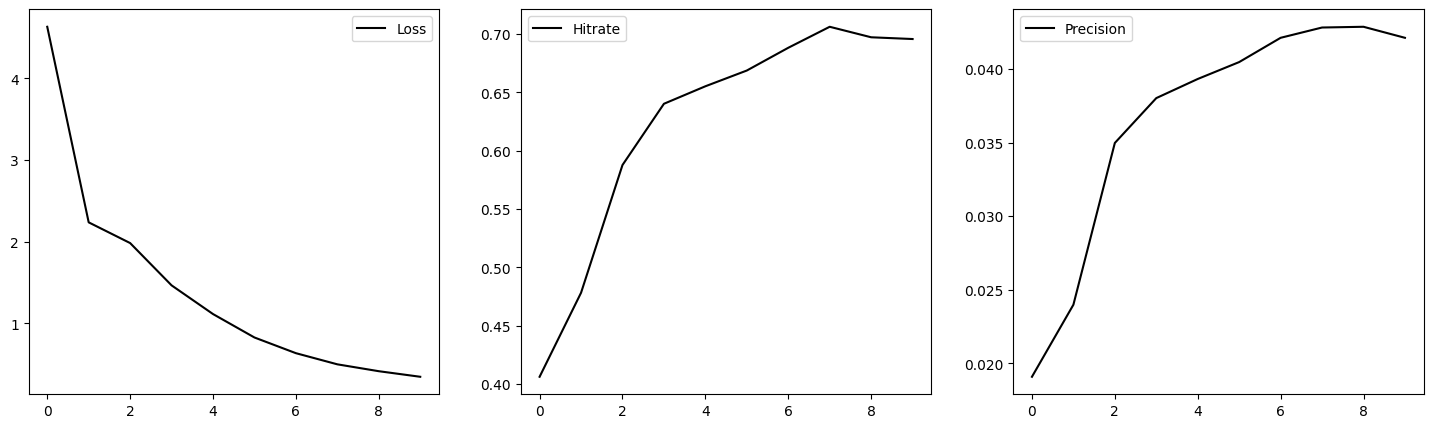

EPOCH LOSS = 0.3476: 100%|██████████| 10/10 [01:19<00:00,  7.96s/it]


In [22]:
epoch_bar = tqdm(range(RUN_PARAMS["n_epochs"]))

metrics = {
    "losses": [],
    "hitrate": [],
    "precision": [],
}

for epoch in epoch_bar:
    metrics["loader_losses"] = []
    model.train()
    for (users, items, labels) in dataloader:
        optimizer.zero_grad()
        logits = model(users, items)
        loss = torch.nn.functional.binary_cross_entropy_with_logits(
            logits, labels,
        )
        loss.backward()
        optimizer.step()

        loader_loss = loss.item()
        metrics["loader_losses"].append(loader_loss)

    # Metrics
    with torch.no_grad():
        model.eval()
        df_preds = get_preds(model, df_val, RUN_PARAMS)
        epoch_loss = sum(metrics["loader_losses"]) / len(metrics["loader_losses"])
        hitrate = calculate_hitrate(df_preds, RUN_PARAMS["K"])
        precision = calculate_precision(df_preds, RUN_PARAMS["K"])

    del df_preds

    metrics["losses"].append(epoch_loss)
    metrics["hitrate"].append(hitrate)
    metrics["precision"].append(precision)

    epoch_bar.set_description(f"EPOCH LOSS = {epoch_loss:.4f}")
    fig = plot(metrics)

In [23]:
with mlflow.start_run(run_name="baseline_LFM"):
    for param, value in NOTEBOOK_PARAMS.items():
        mlflow.log_param(param, value)

    for param, value in RUN_PARAMS.items():
        mlflow.log_param(param, value)

    df_preds = get_preds(model, df_val, RUN_PARAMS)
    hitrate = calculate_hitrate(df_preds, RUN_PARAMS["K"])
    precision = calculate_precision(df_preds, RUN_PARAMS["K"])
    print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

    mlflow.log_metrics(
        {
            'hitrate': hitrate,
            'precision': precision,
        }
    )
    mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])
    mlflow.log_figure(fig, "metrics.png")

Hitrate: 0.6957 | Precision: 0.0421


# Baseline (top-popular)

In [24]:
top_popular = (
    df_train[['node_index']]
    .assign(v=1)
    .groupby('node_index')
    .count()
    .reset_index()
    .sort_values(by='v')
    .tail(RUN_PARAMS["K"])['node_index'].values
)

In [25]:
users = df_val['user_index'].unique()
df_preds_top_poplular = pd.DataFrame({
    'node_index': [list(top_popular) for i in users],
    'user_index': users,
    'rank': [
        [j for j in range(0, RUN_PARAMS["K"])]
        for i in range(len(users))
    ]
})

df_preds_top_poplular = df_preds_top_poplular.explode([
    'node_index', 'rank',
]).merge(
    df_val[['user_index', 'node_index']].assign(relevant=1).drop_duplicates(),
    on=['user_index', 'node_index'],
    how='left',
)
df_preds_top_poplular['relevant'] = df_preds_top_poplular['relevant'].fillna(0)

In [26]:
with mlflow.start_run(run_name="baseline_top_popular"):
    for param, value in NOTEBOOK_PARAMS.items():
        mlflow.log_param(param, value)

    for param, value in RUN_PARAMS.items():
        mlflow.log_param(param, None)

    hitrate = calculate_hitrate(df_preds_top_poplular, RUN_PARAMS["K"])
    precision = calculate_precision(df_preds_top_poplular, RUN_PARAMS["K"])
    print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

    mlflow.log_metrics(
        {
            'hitrate': hitrate,
            'precision': precision,
        }
    )
    mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])
    mlflow.log_figure(fig, "metrics.png")

Hitrate: 0.4438 | Precision: 0.0205


# Experiments

In [30]:
def run(
    batch_size, n_negatives, edim, n_epochs,
    optimizer_name, learning_rate, n_trials,
    run_name: str = "baseline",
) -> float:
    run_params = {
        "batch_size": batch_size,
        "n_negatives": n_negatives,
        "edim": edim,
        "n_epochs": n_epochs,
        "optimizer_name": optimizer_name,
        "learning_rate": learning_rate,
        "n_workers": 0,
        "K": 30,
        "n_trials": n_trials,
    }
    train_dataset = RecDataset(
        df_train['user_index'].values,
        df_train['node_index'].values,
        user2seen,
    )

    dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        num_workers=run_params["n_workers"],
        batch_size=run_params["batch_size"],
        collate_fn=lambda batch: collate_fn(
            batch=batch,
            num_negatives=run_params["n_negatives"],
            num_items=df['node_index'].max(),
        ),
    )

    model = LatentFactorModel(
        run_params["edim"], user_indes, node_indes,
    )
    optimizers = {
        "Adam": torch.optim.Adam(model.parameters(), run_params["learning_rate"]),
        "SGD": torch.optim.SGD(model.parameters(), run_params["learning_rate"]),
        "RMSprop": torch.optim.RMSprop(model.parameters(), run_params["learning_rate"]),
        "AdamW": torch.optim.AdamW(model.parameters(), run_params["learning_rate"]),
        "Adagrad": torch.optim.Adagrad(model.parameters(), run_params["learning_rate"]),
    }
    optimizer = optimizers[run_params["optimizer_name"]]

    print(run_params)

    epoch_bar = tqdm(range(run_params["n_epochs"]))
    metrics = {
        "losses": [],
        "hitrate": [],
        "precision": [],
    }

    for epoch in epoch_bar:
        metrics["loader_losses"] = []
        model.train()
        for (users, items, labels) in dataloader:
            optimizer.zero_grad()
            logits = model(users, items)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                logits, labels,
            )
            loss.backward()
            optimizer.step()

            loader_loss = loss.item()
            metrics["loader_losses"].append(loader_loss)

        # Metrics
        with torch.no_grad():
            model.eval()
            df_preds = get_preds(model, df_val, run_params)
            epoch_loss = sum(metrics["loader_losses"]) / len(metrics["loader_losses"])
            hitrate = calculate_hitrate(df_preds, run_params["K"])
            precision = calculate_precision(df_preds, run_params["K"])

        del df_preds

        metrics["losses"].append(epoch_loss)
        metrics["hitrate"].append(hitrate)
        metrics["precision"].append(precision)

        epoch_bar.set_description(f"EPOCH LOSS = {epoch_loss:.4f}")
        fig = plot(metrics)

    with mlflow.start_run(run_name=run_name):
        for param, value in NOTEBOOK_PARAMS.items():
            mlflow.log_param(param, value)

        for param, value in run_params.items():
            mlflow.log_param(param, value)

        with torch.no_grad():
            model.eval()
            df_preds = get_preds(model, df_val, run_params)

        hitrate = calculate_hitrate(df_preds, run_params["K"])
        precision = calculate_precision(df_preds, run_params["K"])
        print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

        mlflow.log_metrics(
            {
                'hitrate': hitrate,
                'precision': precision,
            }
        )
        mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])
        mlflow.log_figure(fig, "metrics.png")

    return precision

In [31]:
N_TRIALS = 5

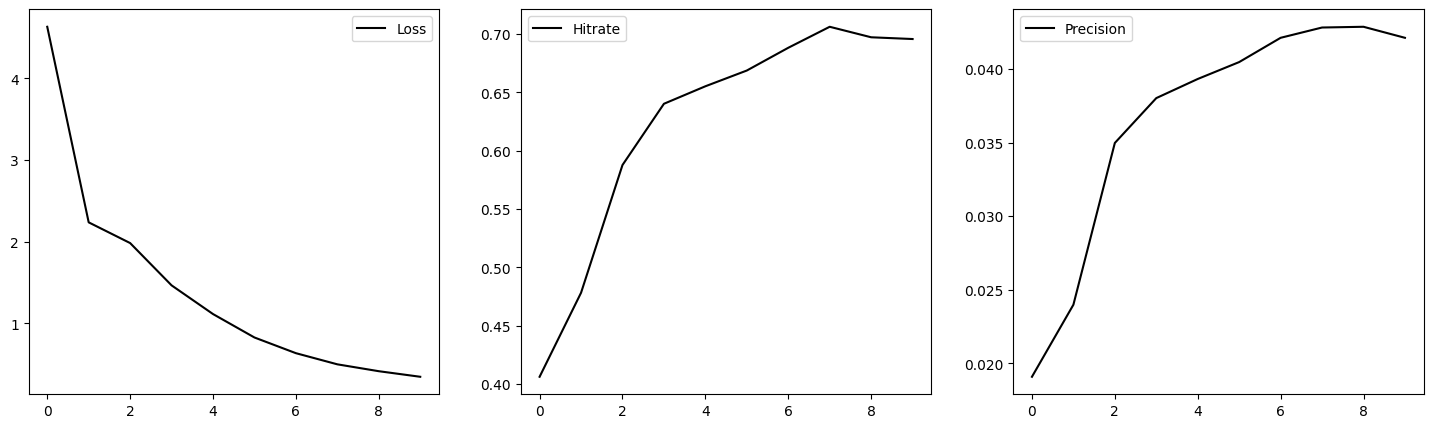

EPOCH LOSS = 0.3476: 100%|██████████| 10/10 [01:12<00:00,  7.29s/it]


Hitrate: 0.6957 | Precision: 0.0421


In [32]:
# Repeat baseline
seed_everything(NOTEBOOK_PARAMS["seed"])
precision = run(
    batch_size=RUN_PARAMS["batch_size"],
    n_negatives=RUN_PARAMS["n_negatives"],
    edim=RUN_PARAMS["edim"],
    n_epochs=RUN_PARAMS["n_epochs"],
    optimizer_name=RUN_PARAMS["optimizer_name"],
    learning_rate=RUN_PARAMS["learning_rate"],
    n_trials=N_TRIALS,
    run_name='baseline',
)

In [33]:
N_TRIALS = 50

In [34]:
def objective(trial) -> float:
    seed_everything(NOTEBOOK_PARAMS["seed"])
    batch_size = trial.suggest_categorical('batch_size', [5000, 10000, 30000, 50000])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-2, 10)
    n_negatives = trial.suggest_int('n_negatives', 1, 10)
    edim = trial.suggest_int('edim', 32, 256)
    n_epochs = trial.suggest_int('n_epochs', 5, 30)
    optimizer_name = trial.suggest_categorical("optimizer_name", [
        "Adam", "SGD", "RMSprop", "AdamW", "Adagrad",
    ])

    precision = run(
        batch_size=batch_size,
        n_negatives=n_negatives,
        edim=edim,
        n_epochs=n_epochs,
        optimizer_name=optimizer_name,
        learning_rate=learning_rate,
        n_trials=N_TRIALS,
        run_name='LFM_optuna',
    )
    return precision

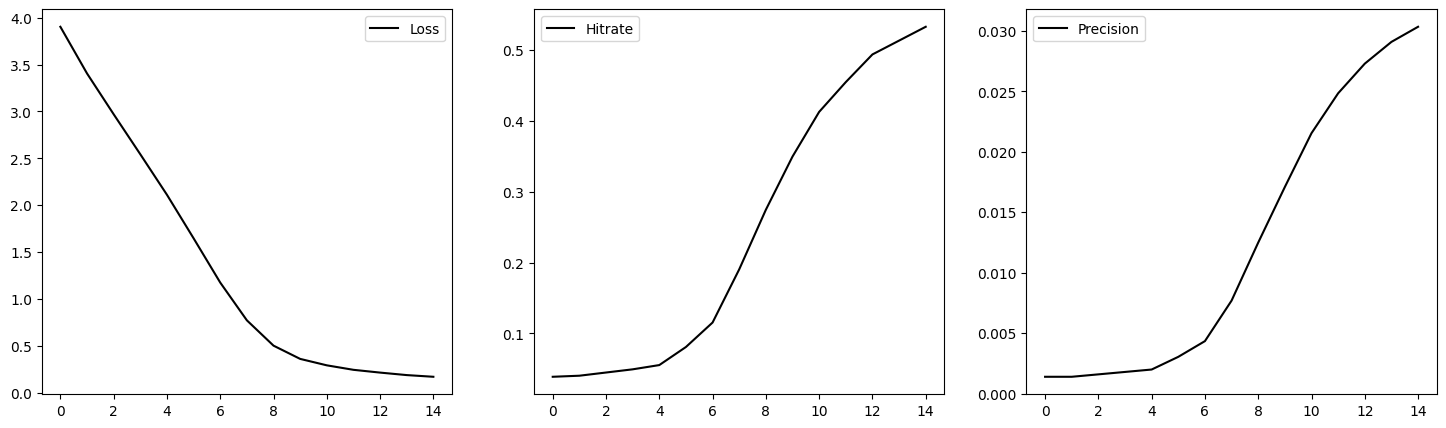

EPOCH LOSS = 0.1718: 100%|██████████| 15/15 [01:58<00:00,  7.88s/it]


Hitrate: 0.5322 | Precision: 0.0303


[I 2024-06-22 16:03:11,124] Trial 49 finished with value: 0.030334832583708143 and parameters: {'batch_size': 30000, 'learning_rate': 0.024729160787450043, 'n_negatives': 10, 'edim': 102, 'n_epochs': 15, 'optimizer_name': 'AdamW'}. Best is trial 34 with value: 0.05057471264367816.


In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

# ALS Model

In [36]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 19.7 MB/s eta 0:00:00


In [37]:
import numpy as np
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares

In [38]:
run_params = {
    "factors": 100,
    "regularization": 0.01,
    "iterations": 15,
    "alpha": 2.0,
    "n_negatives": 3,
    "n_workers": 0,
    "K": 30,
}

In [39]:
train_dataset = RecDataset(
    df_train['user_index'].values,
    df_train['node_index'].values,
    user2seen,
)

dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    num_workers=run_params["n_workers"],
    batch_size=len(train_dataset),
    collate_fn=lambda batch: collate_fn(
        batch=batch,
        num_negatives=run_params["n_negatives"],
        num_items=df['node_index'].max(),
    ),
)
users, items, labels = next(iter(dataloader))

In [40]:
class ALSModel(nn.Module):
    def __init__(self, factors, regularization, iterations, alpha):
        super(ALSModel, self).__init__()
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            alpha=alpha,
        )
        self.matrix = None
        self.is_train = False

    def fit(self, users, items, labels, n_negatives):
        labels_ = labels.flatten()
        labels_[labels_ == 0] = -1 # dislike
        users_ = np.repeat(users, n_negatives + 1)
        items_ = items.flatten()

        self.matrix = csr_matrix(
            (labels_, (users_, items_)), shape=(len(users_), len(items_))
        )
        self.model.fit(self.matrix)
        self.is_train = True

    def pred_top_k(self, user_id, K: int = 30):
        if not self.is_train:
            raise ValueError("Model should be trained")

        ids, scores = self.model.recommend(
            user_id, self.matrix[user_id], N=K,
            filter_already_liked_items=False,
        )
        res = np.array([scores, ids])
        return torch.tensor(res)

In [41]:
model = ALSModel(
    factors=run_params["factors"],
    regularization=run_params["regularization"],
    iterations=run_params["iterations"],
    alpha=run_params["alpha"],
)

/usr/local/lib/python3.10/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


In [42]:
model.fit(users, items, labels, run_params["n_negatives"])

  0%|          | 0/15 [00:00<?, ?it/s]

In [43]:
df_preds = get_preds(model, df_val, run_params)
hitrate = calculate_hitrate(df_preds, run_params["K"])
precision = calculate_precision(df_preds, run_params["K"])
print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

Hitrate: 0.7376 | Precision: 0.0497


# ALS Pipeline

In [44]:
def run_als(
    factors, regularization, iterations, n_trials,
    n_negatives, alpha,
    run_name: str = "baseline",
) -> float:
    run_params = {
        "factors": factors,
        "regularization": regularization,
        "iterations": iterations,
        "alpha": alpha,
        "n_negatives": n_negatives,
        "n_workers": 0,
        "K": 30,
        "n_trials": n_trials,
    }

    print(run_params)
    model = ALSModel(
        factors=run_params["factors"],
        regularization=run_params["regularization"],
        iterations=run_params["iterations"],
        alpha=run_params["alpha"],
    )

    dataloader = DataLoader(
        train_dataset,
        shuffle=True,
        num_workers=run_params["n_workers"],
        batch_size=len(train_dataset),
        collate_fn=lambda batch: collate_fn(
            batch=batch,
            num_negatives=run_params["n_negatives"],
            num_items=df['node_index'].max(),
        ),
    )
    users, items, labels = next(iter(dataloader))
    model.fit(users, items, labels, run_params["n_negatives"])

    with mlflow.start_run(run_name=run_name):
        for param, value in NOTEBOOK_PARAMS.items():
            mlflow.log_param(param, value)

        for param, value in run_params.items():
            mlflow.log_param(param, value)

        with torch.no_grad():
            model.eval()
            df_preds = get_preds(model, df_val, run_params)

        hitrate = calculate_hitrate(df_preds, run_params["K"])
        precision = calculate_precision(df_preds, run_params["K"])
        print(f"Hitrate: {hitrate:.4f} | Precision: {precision:.4f}")

        mlflow.log_metrics(
            {
                'hitrate': hitrate,
                'precision': precision,
            }
        )
        mlflow.log_artifact(NOTEBOOK_PARAMS["notebook_path"])

    return precision

In [45]:
N_TRIALS = 50

In [46]:
def objective(trial) -> float:
    seed_everything(NOTEBOOK_PARAMS["seed"])
    factors = trial.suggest_int('factors', 10, 300)
    regularization = trial.suggest_float('regularization', 1e-3, 5)
    iterations = trial.suggest_int('iterations', 10, 50)
    n_negatives = trial.suggest_int('n_negatives', 1, 10)
    alpha = trial.suggest_float("alpha", 0.1, 15)

    precision = run_als(
        factors=factors,
        regularization=regularization,
        iterations=iterations,
        n_negatives=n_negatives,
        alpha=alpha,
        n_trials=N_TRIALS,
        run_name='ALS_optuna',
    )
    return precision

In [47]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS)

[I 2024-06-22 16:04:21,410] A new study created in memory with name: no-name-5515fe5d-4d05-462c-ba17-5f95e70d8372


{'factors': 201, 'regularization': 1.1378839652311856, 'iterations': 43, 'alpha': 2.9380981769117405, 'n_negatives': 9, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/43 [00:00<?, ?it/s]

Hitrate: 0.7361 | Precision: 0.0477


[I 2024-06-22 16:07:52,465] Trial 0 finished with value: 0.047726136931534234 and parameters: {'factors': 201, 'regularization': 1.1378839652311856, 'iterations': 43, 'n_negatives': 9, 'alpha': 2.9380981769117405}. Best is trial 0 with value: 0.047726136931534234.


{'factors': 52, 'regularization': 1.7484236579357282, 'iterations': 17, 'alpha': 4.529013579050397, 'n_negatives': 1, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/17 [00:00<?, ?it/s]

Hitrate: 0.7436 | Precision: 0.0484


[I 2024-06-22 16:08:10,915] Trial 1 finished with value: 0.04842578710644677 and parameters: {'factors': 52, 'regularization': 1.7484236579357282, 'iterations': 17, 'n_negatives': 1, 'alpha': 4.529013579050397}. Best is trial 1 with value: 0.04842578710644677.


{'factors': 81, 'regularization': 3.551870634273979, 'iterations': 33, 'alpha': 5.367168619058914, 'n_negatives': 5, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/33 [00:00<?, ?it/s]

Hitrate: 0.7406 | Precision: 0.0490


[I 2024-06-22 16:09:09,965] Trial 2 finished with value: 0.049025487256371805 and parameters: {'factors': 81, 'regularization': 3.551870634273979, 'iterations': 33, 'n_negatives': 5, 'alpha': 5.367168619058914}. Best is trial 2 with value: 0.049025487256371805.


{'factors': 159, 'regularization': 4.431408174535382, 'iterations': 46, 'alpha': 12.90310977184974, 'n_negatives': 9, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/46 [00:00<?, ?it/s]

Hitrate: 0.7481 | Precision: 0.0486


[I 2024-06-22 16:12:22,941] Trial 3 finished with value: 0.04862568715642179 and parameters: {'factors': 159, 'regularization': 4.431408174535382, 'iterations': 46, 'n_negatives': 9, 'alpha': 12.90310977184974}. Best is trial 2 with value: 0.049025487256371805.


{'factors': 256, 'regularization': 0.40852353102755445, 'iterations': 49, 'alpha': 11.565422486683785, 'n_negatives': 4, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/49 [00:00<?, ?it/s]

Hitrate: 0.7361 | Precision: 0.0474


[I 2024-06-22 16:15:10,436] Trial 4 finished with value: 0.04737631184407796 and parameters: {'factors': 256, 'regularization': 0.40852353102755445, 'iterations': 49, 'n_negatives': 4, 'alpha': 11.565422486683785}. Best is trial 2 with value: 0.049025487256371805.


{'factors': 216, 'regularization': 4.873265833367954, 'iterations': 21, 'alpha': 8.671227687571385, 'n_negatives': 9, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/21 [00:00<?, ?it/s]

Hitrate: 0.7436 | Precision: 0.0498


[I 2024-06-22 16:17:15,141] Trial 5 finished with value: 0.049825087456271865 and parameters: {'factors': 216, 'regularization': 4.873265833367954, 'iterations': 21, 'n_negatives': 9, 'alpha': 8.671227687571385}. Best is trial 5 with value: 0.049825087456271865.


{'factors': 25, 'regularization': 2.312545314399185, 'iterations': 34, 'alpha': 2.3062398447139327, 'n_negatives': 1, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/34 [00:00<?, ?it/s]

Hitrate: 0.7301 | Precision: 0.0456


[I 2024-06-22 16:17:38,106] Trial 6 finished with value: 0.04557721139430285 and parameters: {'factors': 25, 'regularization': 2.312545314399185, 'iterations': 34, 'n_negatives': 1, 'alpha': 2.3062398447139327}. Best is trial 5 with value: 0.049825087456271865.


{'factors': 10, 'regularization': 4.1377834026575115, 'iterations': 15, 'alpha': 6.070469997021263, 'n_negatives': 9, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/15 [00:00<?, ?it/s]

Hitrate: 0.6672 | Precision: 0.0395


[I 2024-06-22 16:18:01,318] Trial 7 finished with value: 0.03953023488255872 and parameters: {'factors': 10, 'regularization': 4.1377834026575115, 'iterations': 15, 'n_negatives': 9, 'alpha': 6.070469997021263}. Best is trial 5 with value: 0.049825087456271865.


{'factors': 216, 'regularization': 0.8310759284443227, 'iterations': 33, 'alpha': 5.184692448871174, 'n_negatives': 10, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/33 [00:00<?, ?it/s]

Hitrate: 0.7346 | Precision: 0.0471


[I 2024-06-22 16:21:21,880] Trial 8 finished with value: 0.047126436781609195 and parameters: {'factors': 216, 'regularization': 0.8310759284443227, 'iterations': 33, 'n_negatives': 10, 'alpha': 5.184692448871174}. Best is trial 5 with value: 0.049825087456271865.


{'factors': 140, 'regularization': 1.4829305931529262, 'iterations': 27, 'alpha': 5.644326969799753, 'n_negatives': 10, 'n_workers': 0, 'K': 30, 'n_trials': 50}


  0%|          | 0/27 [00:00<?, ?it/s]

Hitrate: 0.7436 | Precision: 0.0485


[I 2024-06-22 16:23:11,317] Trial 9 finished with value: 0.04847576211894052 and parameters: {'factors': 140, 'regularization': 1.4829305931529262, 'iterations': 27, 'n_negatives': 10, 'alpha': 5.644326969799753}. Best is trial 5 with value: 0.049825087456271865.


{'factors': 287, 'regularization': 3.1999966856237663, 'iterations': 10, 'alpha': 9.705746923417083, 'n_negatives': 7, 'n_workers': 0, 'K': 30, 'n_trials': 50}


[W 2024-06-22 16:23:15,356] Trial 10 failed with parameters: {'factors': 287, 'regularization': 3.1999966856237663, 'iterations': 10, 'n_negatives': 7, 'alpha': 9.705746923417083} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-46-dab77832726a>", line 9, in objective
    precision = run_als(
  File "<ipython-input-44-b5134a977dbf>", line 36, in run_als
    users, items, labels = next(iter(dataloader))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 631, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 675, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 

KeyboardInterrupt: 